In [1]:
import sys
import os
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive

    drive.mount('/gdrive')
    % cd / gdrive / My Drive / ANNDL-H1 /
    !pip install sklearn
    !pip install visualkeras

import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import keras_cv as keras_cv
#OUR CUSTOM HELPER CLASS
sys.path.append('../../../Utils/')
from DatasetHelper import *
from ModelHelper import ModelHelper

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [2]:

dataset_dir = '../../data'
training_dir = os.path.join(dataset_dir, '')

In [3]:
#Create Instances Of Utils Helper
seed = 5000
labels = {0: 'Species1', 1: 'Species2', 2: 'Species3', 3: 'Species4', 4: 'Species5', 5: 'Species6', 6: 'Species7',
          7: 'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../", seed, create_dirs=True)  #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper = ModelHelper("../../", labels)  #take in input local models folder and lables
model_helper.create_seed(tf, seed);



In [4]:
#Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]

In [5]:
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train

In [6]:
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 15000, disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1), seed=4567)

Data Augmentation with data distribution
Data distribution = [0.13875    0.12021667 0.12108333 0.12135    0.12028333 0.13675
 0.12001667 0.12155   ]
Class Size :  149, generating: 2081
1937 images generated
Class Size :  427, generating: 1803
1708 images generated
Class Size :  414, generating: 1816
1784 images generated
Class Size :  410, generating: 1820
1768 images generated
Class Size :  426, generating: 1804
1704 images generated
Class Size :  179, generating: 2051
1918 images generated
Class Size :  430, generating: 1800
1720 images generated
Class Size :  407, generating: 1823
1756 images generated


In [7]:
X_train, Y_train = dataset_helper.keras_cv_augmentation(X_train, Y_train, 0.1)

Metal device set to: Apple M1 Pro


2022-11-22 01:56:46.468933: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-22 01:56:46.469322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-22 01:56:47.085324: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-22 01:56:53.126673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [8]:
input_shape = X_train.shape[1:]  # 96*96*3
batch_size = 128
epochs = 50

In [9]:
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    depth = 8
    start_n_f = 32
    last_layer = input_layer

    # last_layer = keras_cv.layers.GridMask(
    #     ratio_factor=(0, 0.5),
    #     rotation_factor=0.15,
    #     fill_mode="constant",
    #     fill_value=0.0,
    # )(last_layer)

    for i in range(depth):
        kernel_size = (3, 3) if i == 0 else (3, 3)
        conv = tfkl.Conv2D(
            filters=start_n_f,
            kernel_size=kernel_size,
            strides=(1, 1),
            padding='same',
            activation=None,
            kernel_initializer=tfk.initializers.HeUniform(seed)
        )(last_layer)
        batch = BatchNormalization()(conv)
        activation = tfkl.Activation('relu')(batch)
        last_layer = activation
        if i % 2 == 0:
            pool = tfkl.MaxPooling2D((2, 2), padding='same')(activation)
            last_layer = pool
            start_n_f *= (1 if i % 2 == 0 else 2)

    flattening_layer = tfkl.Flatten(name='Flatten')(last_layer)
    classifier_layer = tfkl.Dense(
        units=1024,
        name='Classifier',
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed)
    )(flattening_layer)
    classifier_layer = tfkl.Dropout(0.5, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(
        units=8,
        activation='softmax',
        kernel_initializer=tfk.initializers.GlorotUniform(seed),
        name='Output'
    )(classifier_layer)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [10]:
model = build_model(input_shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248  

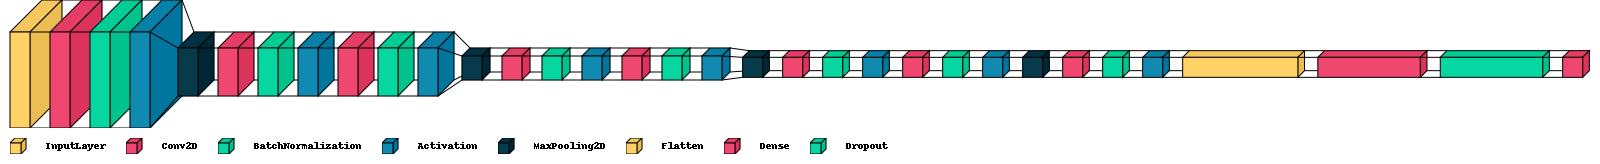

In [11]:
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

In [12]:
X_val.shape, Y_val.shape

((354, 96, 96, 3), (354, 8))

In [13]:
# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=25)

#Fit the model
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks_selected
).history

Epoch 1/100


2022-11-22 01:56:58.623188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - ETA: 0s - loss: 1.7815 - accuracy: 0.3270

2022-11-22 01:57:11.078291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 13s 64ms/step - loss: 1.7815 - accuracy: 0.3270 - val_loss: 1.7526 - val_accuracy: 0.3446
Epoch 2/100
196/196 [==============================] - 12s 61ms/step - loss: 1.4503 - accuracy: 0.4589 - val_loss: 1.3278 - val_accuracy: 0.4915
Epoch 3/100
196/196 [==============================] - 12s 61ms/step - loss: 1.3270 - accuracy: 0.5124 - val_loss: 1.3192 - val_accuracy: 0.4972
Epoch 4/100
196/196 [==============================] - 12s 61ms/step - loss: 1.2160 - accuracy: 0.5605 - val_loss: 1.1063 - val_accuracy: 0.6215
Epoch 5/100
196/196 [==============================] - 12s 61ms/step - loss: 1.1247 - accuracy: 0.5965 - val_loss: 1.0023 - val_accuracy: 0.6412
Epoch 6/100
196/196 [==============================] - 12s 61ms/step - loss: 1.0522 - accuracy: 0.6276 - val_loss: 1.3017 - val_accuracy: 0.5141
Epoch 7/100
196/196 [==============================] - 12s 61ms/step - loss: 0.9905 - accuracy: 0.6579 - val_loss: 1.7389 - val_accuracy: 0.45

In [18]:
model_helper.save_model(model, 'model1')

INFO:tensorflow:Assets written to: ../../local_saved_models/model1/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model1/assets


In [19]:
model = model_helper.load_model('model1')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248  

 7/12 [================>.............] - ETA: 0s

2022-11-22 02:13:26.945499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 13ms/step
Accuracy: 0.7034
Precision: 0.6951
Recall: 0.6595
F1: 0.6667


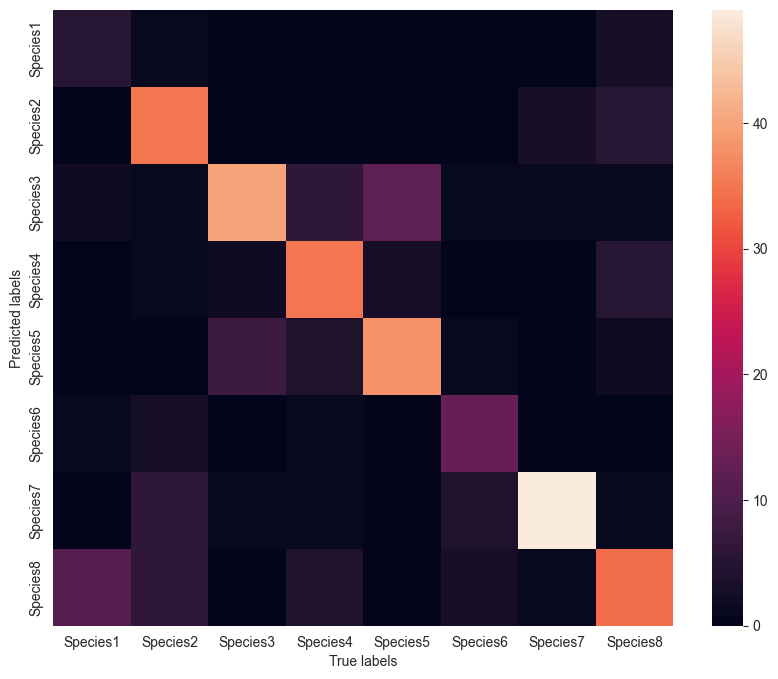

In [20]:
model_helper.show_confusion_matrix(X_test, Y_test)

In [21]:
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 15000, disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1), seed=4578)
X_train, Y_train = dataset_helper.keras_cv_augmentation(X_train, Y_train, 0.1)

Data Augmentation with data distribution
Data distribution = [0.13875    0.12021667 0.12108333 0.12135    0.12028333 0.13675
 0.12001667 0.12155   ]
Class Size :  149, generating: 2081
1937 images generated
Class Size :  427, generating: 1803
1708 images generated
Class Size :  414, generating: 1816
1784 images generated
Class Size :  410, generating: 1820
1768 images generated
Class Size :  426, generating: 1804
1704 images generated
Class Size :  179, generating: 2051
1918 images generated
Class Size :  430, generating: 1800
1720 images generated
Class Size :  407, generating: 1823
1756 images generated


In [22]:
# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=25)

#Fit the model
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks_selected
).history

Epoch 1/100


2022-11-22 02:14:53.684041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.7637

2022-11-22 02:15:06.231037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 14s 65ms/step - loss: 0.7137 - accuracy: 0.7637 - val_loss: 1.2504 - val_accuracy: 0.6751
Epoch 2/100
196/196 [==============================] - 12s 63ms/step - loss: 0.4623 - accuracy: 0.8361 - val_loss: 1.0888 - val_accuracy: 0.7034
Epoch 3/100
196/196 [==============================] - 12s 63ms/step - loss: 0.3520 - accuracy: 0.8785 - val_loss: 1.3269 - val_accuracy: 0.7062
Epoch 4/100
196/196 [==============================] - 12s 63ms/step - loss: 0.2801 - accuracy: 0.9043 - val_loss: 1.2936 - val_accuracy: 0.7147
Epoch 5/100
196/196 [==============================] - 12s 63ms/step - loss: 0.2296 - accuracy: 0.9186 - val_loss: 1.8882 - val_accuracy: 0.6780
Epoch 6/100
196/196 [==============================] - 12s 63ms/step - loss: 0.1806 - accuracy: 0.9375 - val_loss: 1.1937 - val_accuracy: 0.7232
Epoch 7/100
196/196 [==============================] - 12s 63ms/step - loss: 0.1774 - accuracy: 0.9375 - val_loss: 1.3906 - val_accuracy: 0.70

In [23]:
model_helper.save_model(model, 'model2')

INFO:tensorflow:Assets written to: ../../local_saved_models/model2/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model2/assets


In [24]:
model = model_helper.load_model('model2')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248  

12/12 [==============================] - 0s 11ms/step


2022-11-22 02:26:30.343341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Accuracy: 0.774
Precision: 0.7639
Recall: 0.7376
F1: 0.7441


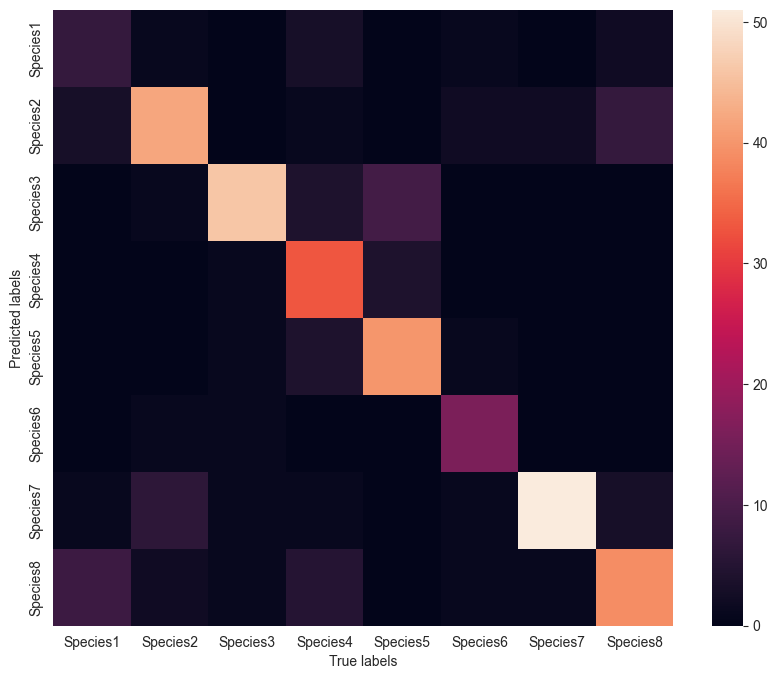

In [25]:
#PLOT CONFUSION MATRIX OF OUR MODEL
#It is good if diagonal has high values and other part of matrix is dark
#Bad if a row has ALL dark cells
#EG species 1 and species 6 has less images in the datase... and here the confusion matrix has all black on them..
model_helper.show_confusion_matrix(X_test, Y_test)

In [26]:
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 15000, disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1), seed=12)
X_train, Y_train = dataset_helper.keras_cv_augmentation(X_train, Y_train, 0.1)
# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=25)

#Fit the model
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks_selected
).history

Data Augmentation with data distribution
Data distribution = [0.13875    0.12021667 0.12108333 0.12135    0.12028333 0.13675
 0.12001667 0.12155   ]
Class Size :  149, generating: 2081
1937 images generated
Class Size :  427, generating: 1803
1708 images generated
Class Size :  414, generating: 1816
1784 images generated
Class Size :  410, generating: 1820
1768 images generated
Class Size :  426, generating: 1804
1704 images generated
Class Size :  179, generating: 2051
1918 images generated
Class Size :  430, generating: 1800
1720 images generated
Class Size :  407, generating: 1823
1756 images generated
Epoch 1/100


2022-11-22 02:27:10.976841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - ETA: 0s - loss: 0.6430 - accuracy: 0.8028

2022-11-22 02:27:23.538593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 14s 65ms/step - loss: 0.6430 - accuracy: 0.8028 - val_loss: 1.0461 - val_accuracy: 0.7571
Epoch 2/100
196/196 [==============================] - 12s 63ms/step - loss: 0.3686 - accuracy: 0.8723 - val_loss: 1.0377 - val_accuracy: 0.7373
Epoch 3/100
196/196 [==============================] - 12s 63ms/step - loss: 0.2781 - accuracy: 0.9048 - val_loss: 0.9424 - val_accuracy: 0.7881
Epoch 4/100
196/196 [==============================] - 12s 63ms/step - loss: 0.2144 - accuracy: 0.9245 - val_loss: 1.3876 - val_accuracy: 0.7429
Epoch 5/100
196/196 [==============================] - 13s 65ms/step - loss: 0.1758 - accuracy: 0.9404 - val_loss: 1.4387 - val_accuracy: 0.7288
Epoch 6/100
196/196 [==============================] - 12s 63ms/step - loss: 0.1402 - accuracy: 0.9513 - val_loss: 1.1083 - val_accuracy: 0.7938
Epoch 7/100
196/196 [==============================] - 12s 63ms/step - loss: 0.1385 - accuracy: 0.9538 - val_loss: 1.0783 - val_accuracy: 0.79

INFO:tensorflow:Assets written to: ../../local_saved_models/model3/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model3/assets


12/12 [==============================] - 0s 11ms/step


2022-11-22 02:42:38.819692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Accuracy: 0.7881
Precision: 0.7798
Recall: 0.7639
F1: 0.7658


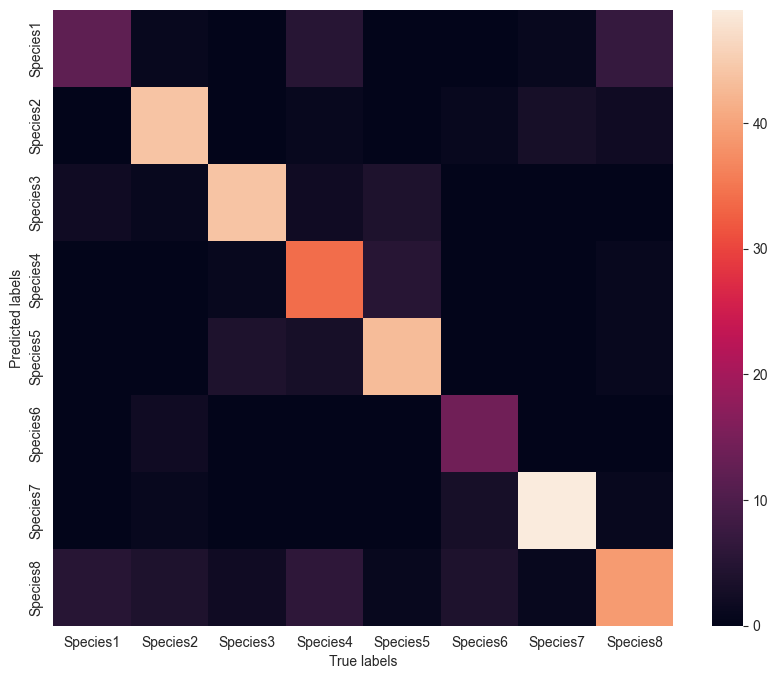

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248  

In [27]:
model_helper.save_model(model, 'model3')
model = model_helper.load_model('model3')
model_helper.show_confusion_matrix(X_test, Y_test)

model.summary()

In [28]:
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 15000, disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1), seed=453)
X_train, Y_train = dataset_helper.keras_cv_augmentation(X_train, Y_train, 0.1)
# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=25)

#Fit the model
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks_selected
).history

Data Augmentation with data distribution
Data distribution = [0.13875    0.12021667 0.12108333 0.12135    0.12028333 0.13675
 0.12001667 0.12155   ]
Class Size :  149, generating: 2081
1937 images generated
Class Size :  427, generating: 1803
1708 images generated
Class Size :  414, generating: 1816
1784 images generated
Class Size :  410, generating: 1820
1768 images generated
Class Size :  426, generating: 1804
1704 images generated
Class Size :  179, generating: 2051
1918 images generated
Class Size :  430, generating: 1800
1720 images generated
Class Size :  407, generating: 1823
1756 images generated
Epoch 1/100


2022-11-22 02:43:19.038030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - ETA: 0s - loss: 0.5907 - accuracy: 0.8357

2022-11-22 02:43:31.606919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 14s 65ms/step - loss: 0.5907 - accuracy: 0.8357 - val_loss: 0.9912 - val_accuracy: 0.7458
Epoch 2/100
196/196 [==============================] - 12s 63ms/step - loss: 0.3192 - accuracy: 0.8905 - val_loss: 1.0874 - val_accuracy: 0.7316
Epoch 3/100
196/196 [==============================] - 12s 62ms/step - loss: 0.2282 - accuracy: 0.9213 - val_loss: 0.9625 - val_accuracy: 0.7881
Epoch 4/100
196/196 [==============================] - 12s 63ms/step - loss: 0.1771 - accuracy: 0.9386 - val_loss: 0.9326 - val_accuracy: 0.7825
Epoch 5/100
196/196 [==============================] - 12s 63ms/step - loss: 0.1469 - accuracy: 0.9499 - val_loss: 0.9657 - val_accuracy: 0.7797
Epoch 6/100
196/196 [==============================] - 12s 62ms/step - loss: 0.1173 - accuracy: 0.9600 - val_loss: 1.1063 - val_accuracy: 0.7712
Epoch 7/100
196/196 [==============================] - 12s 63ms/step - loss: 0.0971 - accuracy: 0.9659 - val_loss: 1.0439 - val_accuracy: 0.80

INFO:tensorflow:Assets written to: ../../local_saved_models/model4/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model4/assets


12/12 [==============================] - 0s 11ms/step


2022-11-22 02:50:23.057281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Accuracy: 0.8164
Precision: 0.7858
Recall: 0.7791
F1: 0.7803


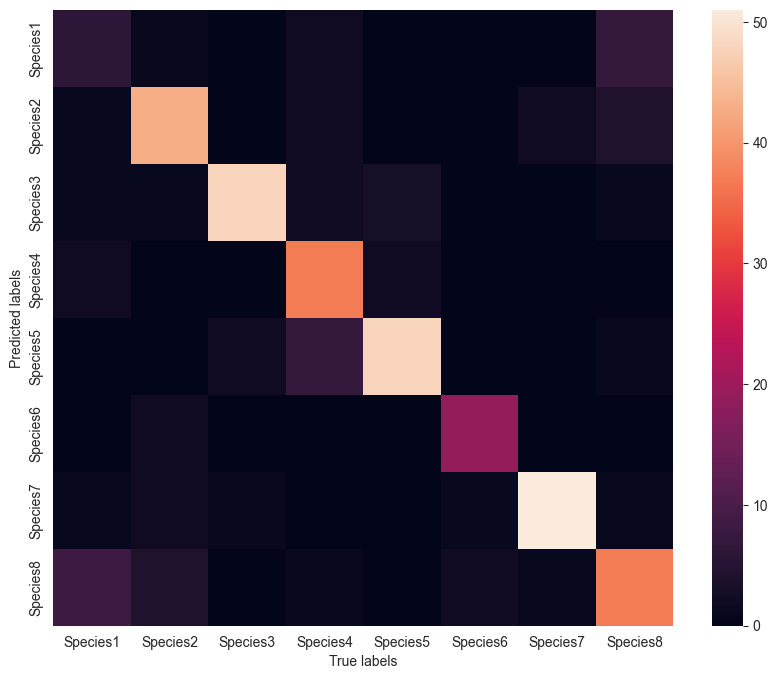

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248  

In [29]:
model_helper.save_model(model, 'model4')
model = model_helper.load_model('model4')
model_helper.show_confusion_matrix(X_test, Y_test)

model.summary()

In [30]:
#Submission Model for the challenge -> Path is the folder on the server where our script is
class SubmissionModel:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'model1'))

    def predict(self, X):
        # Insert your preprocessing here

        out = self.model.predict(X)
        out = np.argmax(out, axis=-1)
        return out

In [31]:
testing_index = 44
image_to_test = X_test[[testing_index], :]
#image_to_test = X_test[10,None,:]
#image_to_test = np.expand_dims(image_to_test,0)
image_to_test.shape


(1, 96, 96, 3)

In [32]:
print("Real Class: ")
print(labels[np.argmax(Y_test[testing_index])])
tester = SubmissionModel("../../local_saved_models/")
res = tester.predict(image_to_test)
labels[res[0]]

Real Class: 
Species4


2022-11-22 02:50:25.137130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 405ms/step


'Species4'

In [ ]:
#Predict all test at oance
predicted_vector = model.predict(X_test)
predicted_vector.shape